In [21]:
import pandas as pd
from datetime import datetime, timedelta
import os
from tqdm import tqdm
import pickle
tqdm.pandas()
import warnings
import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from utils import create_features_and_target
from utils import create_features_for_prediction
warnings.filterwarnings("ignore")

### Load Initial position and dict of Omni

In [4]:
df_train = pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/00000_to_02284-initial_states.csv')
df_train = pd.concat([df_train,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/02285_to_02357-initial_states.csv')])
df_train = pd.concat([df_train,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/02358_to_04264-initial_states.csv')])
df_train = pd.concat([df_train,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/04265_to_05570-initial_states.csv')])
df_train = pd.concat([df_train,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/05571_to_05614-initial_states.csv')])
df_train = pd.concat([df_train,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/05615_to_06671-initial_states.csv')])
#df_train = pd.concat([df_train,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/06672_to_08118-initial_states.csv')])

df_train['Timestamp'] = pd.to_datetime(df_train['Timestamp'])
df_train = df_train.set_index('File ID')

In [5]:
with open('data/data_isaac/omni.pickle', 'rb') as f:
    omni = pickle.load(f)
with open('data/data_isaac/sat.pickle', 'rb') as f:
    sat = pickle.load(f)

In [ ]:
# all_files_omni = os.listdir("phase_1/omni2/")
# all_files_dens = os.listdir("phase_1/sat_density/")
# omni = {}
# for i in tqdm(all_files_omni):
#     omni[int(i.split('-')[1])] = pd.read_csv('phase_1/omni2/'+i)
# sat = {}
# for i in tqdm(all_files_dens):
#     sat[int(i.replace('gr-of','grof').split('-')[1])] = pd.read_csv('phase_1/sat_density/'+i)
# with open('omni.pickle', 'wb') as handle:
#     pickle.dump(omni, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('sat.pickle', 'wb') as handle:
#     pickle.dump(sat, handle, protocol=pickle.HIGHEST_PROTOCOL)

### XGBOOST

In [ ]:
model = cb.CatBoostRegressor()

In [22]:
res = df_train.reset_index()['File ID'].progress_apply(lambda win:create_features_and_target(win,df_train,omni,sat))

100%|█████████████████████████████████████████████████████████████████████████████| 6672/6672 [00:43<00:00, 152.15it/s]


### Prediction by mean

In [16]:
model_mean = cb.CatBoostRegressor(loss_function='RMSE',iterations=1000)
model_mean.fit(res.drop(['Timestamp', 'mean_Timestamp', 'last_Timestamp','Target'],axis=1).iloc[:6000],res['Target'].iloc[:6000])

Learning rate set to 0.054341
0:	learn: 77392916262148786257074814189568.0000000	total: 9.11ms	remaining: 9.11s
1:	learn: 76921563941516286913490009980928.0000000	total: 16.9ms	remaining: 8.41s
2:	learn: 76466749647504339031727945023488.0000000	total: 25.3ms	remaining: 8.4s
3:	learn: 76055539679031455516098583068672.0000000	total: 33.1ms	remaining: 8.23s
4:	learn: 75709944121303877100515975233536.0000000	total: 40.4ms	remaining: 8.05s
5:	learn: 75359690629295214939439617802240.0000000	total: 47.8ms	remaining: 7.92s
6:	learn: 75069981763960688596543839666176.0000000	total: 55.4ms	remaining: 7.85s
7:	learn: 74528513830921896041084159524864.0000000	total: 62.9ms	remaining: 7.8s
8:	learn: 74259192129814622141606130614272.0000000	total: 70.3ms	remaining: 7.74s
9:	learn: 73880816819243909099122969280512.0000000	total: 77.5ms	remaining: 7.67s
10:	learn: 73608571875395893303734322593792.0000000	total: 85.3ms	remaining: 7.67s
11:	learn: 73256640244360210837941677719552.0000000	total: 92.8ms	rem

In [17]:
model_mean.score(res.drop(['Timestamp', 'mean_Timestamp', 'last_Timestamp','Target'],axis=1).iloc[:6000],res['Target'].iloc[:6000])

0.8957385494471333

In [18]:
model_mean.score(res.drop(['Timestamp', 'mean_Timestamp', 'last_Timestamp','Target'],axis=1).iloc[6000:],res['Target'].iloc[6000:])

-0.03961642727015979

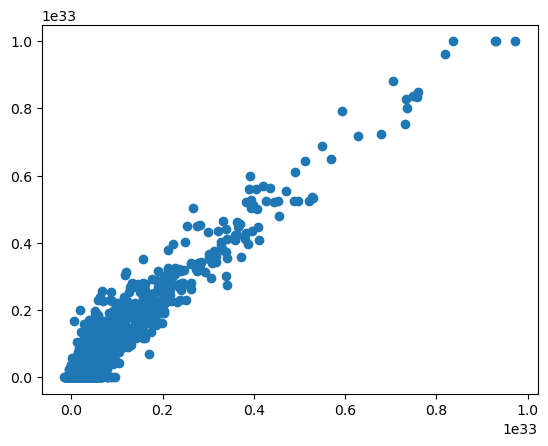

In [20]:
plt.scatter(model_mean.predict(res.drop(['Timestamp', 'mean_Timestamp', 'last_Timestamp','Target'],axis=1).iloc[:6000]),res['Target'].iloc[:6000])

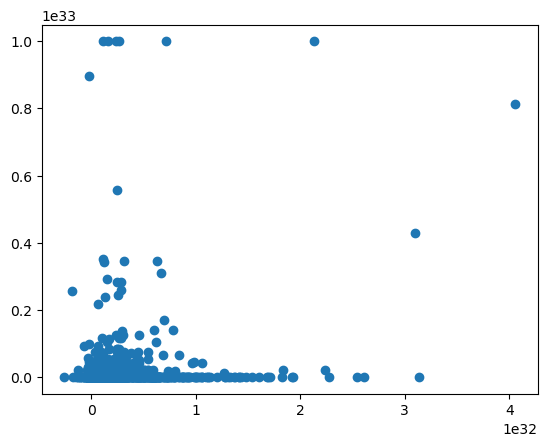

In [19]:
plt.scatter(model_mean.predict(res.drop(['Timestamp', 'mean_Timestamp', 'last_Timestamp','Target'],axis=1).iloc[6000:]),res['Target'].iloc[6000:])

### Prediction by timestamp to predict

In [ ]:
df_training_set = pd.concat(res.iloc[:4000].values)
df_test_set = pd.concat(res.iloc[4000:].values)
df_training_set = df_training_set.drop(['Timestamp', 'mean_Timestamp', 'last_Timestamp'],axis=1)
df_test_set = df_test_set.drop(['Timestamp', 'mean_Timestamp', 'last_Timestamp'],axis=1)
# df_training_set.to_pickle('data_isaac/df_training_set.pkl')
# df_test_set.to_pickle('data_isaac/df_test_set.pkl')
train_dataset = cb.Pool(df_training_set.drop('Orbit Mean Density (kg/m^3)',axis=1), df_training_set['Orbit Mean Density (kg/m^3)']) 
test_dataset = cb.Pool(df_test_set.drop('Orbit Mean Density (kg/m^3)',axis=1), df_test_set['Orbit Mean Density (kg/m^3)'])

In [ ]:
model = cb.CatBoostRegressor(loss_function='RMSE',iterations=20000)
model.fit(train_dataset)

In [ ]:
model.save_model('data_isaac/model_by_timestamp.cbm')

In [ ]:
data = pd.DataFrame({'feature_importance': model.feature_importances_, 
              'feature_names': model.feature_names_}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

In [ ]:
id = 6090
res[id]['Orbit Mean Density (kg/m^3)'].plot()
plt.twinx()
plt.plot(model.predict(res[id]),color='red')

In [ ]:
model.score(test_dataset)


###  Compare pred

In [ ]:
id = 90


In [ ]:
df_pred_by_mean = pd.DataFrame(create_pred_timestamps(df_train['Timestamp'].loc[id]),columns=['Timestamp'])
df_pred_by_mean['Orbit Mean Density (kg/m^3)'] = model_mean.predict(create_features_and_target_by_dict(id,df_train,omni,sat).drop(['Timestamp', 'mean_Timestamp', 'last_Timestamp','Target']))

In [ ]:
pred_feature = create_features_and_target_by_dict(id,df_train,omni,sat,predict_mean=False)
df_pred = pd.DataFrame(model.predict(pred_feature.drop(['Timestamp', 'mean_Timestamp', 'last_Timestamp'],axis=1)),
             index=pred_feature['Timestamp'],columns=['Orbit Mean Density (kg/m^3)']).reset_index()

In [ ]:
df_pred_msis = pd.read_csv('data_isaac/sat_density_pred/density_pred'+str(id)+ '.csv',index_col=0)
df_pred_msis['Timestamp'] = pd.to_datetime(df_pred_msis['Timestamp'])

In [ ]:
df_pred_msis.shape

In [ ]:
df_true = sat[id]

In [ ]:
plt.figure()
df_true.set_index('Timestamp')['Orbit Mean Density (kg/m^3)'].plot()
df_pred.set_index('Timestamp')['Orbit Mean Density (kg/m^3)'].plot()
df_pred_by_mean.set_index('Timestamp')['Orbit Mean Density (kg/m^3)'].plot()
df_pred_msis.set_index('Timestamp')['Density (kg/m3)'].plot()

In [ ]:
df_pred_msis.set_index('Timestamp')['Density (kg/m3)'].plot()


###  Model by MSIS

In [ ]:
from atm_me import PersistenceMSIS, MSISPersistenceAtmosphere, PersistenceModel

In [ ]:
bad_id = []

In [ ]:
model = PersistenceModel(plot_trajectory=False)
for id in df_train.index:
    if os.path.exists('data_isaac/sat_density_pred_no_drag/density_pred'+ str(id) + '.csv'):
        continue
    else:
        bad_id.append(id)
        continue
    omni_data = omni[id].loc[:,['Timestamp', 'f10.7_index', 'ap_index_nT']]
    omni_data['Timestamp'] = pd.to_datetime(omni_data['Timestamp'])
    omni_data = omni_data.ffill()
    try:
        states, densities = model(omni_data,df_train.loc[id].to_dict())
        predictions = model._convert_to_df(states, densities)
        predictions.to_csv('data_isaac/sat_density_pred_no_drag/density_pred'+ str(id) + '.csv')
    except:
        print(id)

In [ ]:
from poliastro.core.elements import coe2rv

In [ ]:
from poliastro.constants.general import GM_earth

In [ ]:
coe2rv(GM_earth,6826.387247,0.003882,87.275306,144.135111,257.314389,102.383270)

In [ ]:
coe2rv(GM_earth,6824.556715,0.004397,87.269194,127.738000,86.817000,273.818611)

In [ ]:
df_train.loc[df_train['Latitude (deg)']<100]

In [ ]:
df_train.loc[bad_id]

In [ ]:
df_train.loc[df_train.index.isin(bad_id)==False]

In [ ]:
len(bad_id)


In [ ]:
from evaluation_me import DensityModelEvaluator

